In [93]:
import json
import sys
sys.path.append('/home/hassaku/research/ambiguous-segmentation/scripts/')

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
%matplotlib inline

from modules.trainer import Trainer

In [7]:
config = json.load(open('../config_test.json', 'r'))
config["output_path"] += "temp/"
config['is_file_saved'] = False
t = Trainer(**config)

  0%|          | 0/100 [00:00<?, ?it/s]

Portrait loaded.


100%|██████████| 100/100 [00:00<00:00, 264.41it/s]
100it [00:00, 6973.89it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

BG loaded.
Finish piling.
Train images loaded.


  0%|          | 0/10 [00:00<?, ?it/s]

Portrait loaded.


100%|██████████| 10/10 [00:00<00:00, 173.38it/s]
10it [00:00, 7598.38it/s]


BG loaded.
Finish piling.
Test images loaded.
Model loaded.


In [21]:
photo_p = '/home/hassaku/dataset/aisegmentcom-matting-human-datasets/matting_human_half/clip_img/1803151818/clip_00000000/1803151818-00000003.jpg'
alpha_p = '/home/hassaku/dataset/aisegmentcom-matting-human-datasets/matting_human_half/matting/1803151818/matting_00000000/1803151818-00000003.png'
photo = Image.open(photo_p)
alpha = Image.open(alpha_p)

In [110]:
transform = transforms.Compose([
    transforms.CenterCrop(512),
    transforms.ToTensor(),
])
photo_t = transform(photo)
alpha_t = transform(alpha)[3, :, :]

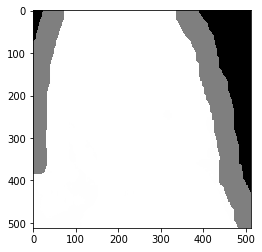

In [111]:
alpha_np = (alpha_t.numpy() * 255).astype('uint8')
alpha_np_rgb = cv2.cvtColor(alpha_np, cv2.COLOR_GRAY2RGB)

kernel = np.ones((3, 3), np.uint8)
edge = cv2.dilate(cv2.Canny(alpha_np_rgb, 100, 200), kernel, iterations = 20)

trimap_np = alpha_np.copy()
trimap_np[edge == 255] = 127
trimap_t = torch.Tensor(trimap_np.astype('float32') / 255)
plt.imshow(trimap_t, cmap='gray')

In [113]:
input_tensor = torch.cat((photo_t, trimap_t.view((1,) + trimap_t.shape)))
input_tensor = input_tensor.view((1,) + input_tensor.shape).cuda()
pred_alpha, _ = t.matting_stage(input_tensor)

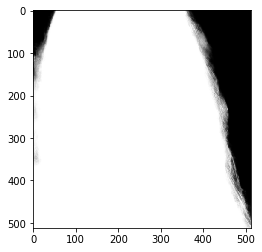

In [122]:
plt.imshow(pred_alpha[0, 0, :, :].cpu(), cmap='gray')